# **Car Object Detection Using Pre-Trained ResNext - Tao Zhang**

Reference：https://www.kaggle.com/code/kimmik123/car-boundary-detection-pytorch/notebook


In [1]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches
import random
import cv2
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Mounted at /content/drive


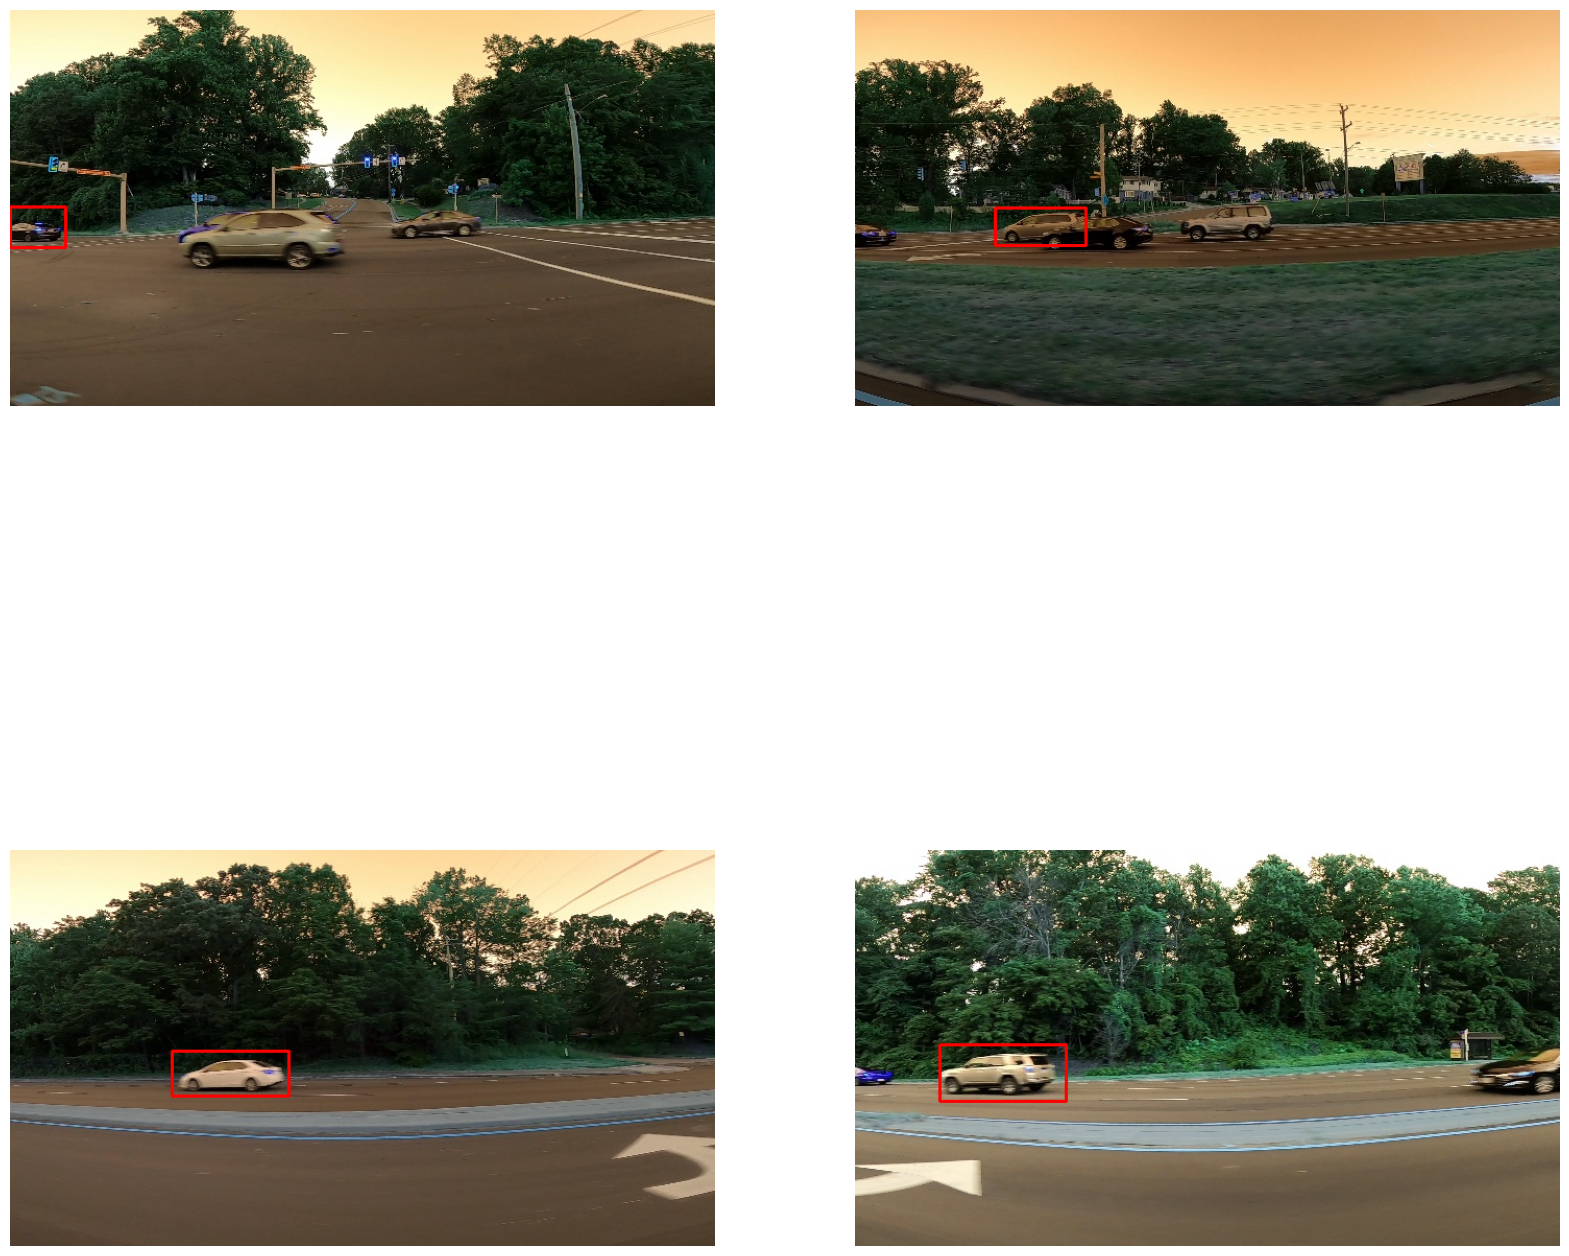

In [2]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/MyDrive/data/training_images/'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_df = pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')
fig = plt.figure(figsize=(20,20))
random_list = random.sample(range(0, train_df.shape[0]), 4)

for i, idx in enumerate(random_list):
    x1, x2, y1, y2 = train_df.iloc[idx,:]['xmin'], train_df.iloc[idx,:]['xmax'], train_df.iloc[idx,:]['ymin'], train_df.iloc[idx,:]['ymax']
    
    image_path = cv2.imread(glob.glob(root + train_df.iloc[idx,:]['image'])[0])
    cv2.rectangle(image_path, (int(x1), int(y1)), (int(x2), int(y2)),(255, 0, 0), 2)
    
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image_path)
    plt.axis('off');

# **Data Processing**

In [3]:
scaler = MinMaxScaler()
train_df[['xmin', 'ymin', 'xmax', 'ymax']] = scaler.fit_transform(train_df[['xmin', 'ymin', 'xmax', 'ymax']])
train_df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,0.435936,0.647541,0.462081,0.226398
1,vid_4_10000.jpg,0.023503,0.647541,0.141748,0.346439
2,vid_4_10040.jpg,0.370735,0.475410,0.514966,0.346439
3,vid_4_10020.jpg,0.769522,0.401639,0.928983,0.301979
4,vid_4_10060.jpg,0.025777,0.639344,0.160635,0.364223
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,0.836707,0.031939,0.344559
555,vid_4_9880.jpg,0.511290,0.135473,0.784791,0.474327
556,vid_4_9900.jpg,0.000000,0.333469,0.174905,0.371407
557,vid_4_9960.jpg,0.755489,0.399467,0.908745,0.277437


In [4]:
train_df.iloc[-32,:]

image    vid_4_9560.jpg
xmin           0.329668
ymin           0.787208
xmax           0.384791
ymax           0.255063
Name: 527, dtype: object

In [5]:
height, width = 224, 224

# Create training transform with TrivialAugment
train_transform_trivial_augment = tt.Compose([
    
    tt.Resize((height, width)),
    tt.TrivialAugmentWide(num_magnitude_bins=31),
    tt.ToTensor(),
    tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create testing transform (no data augmentation)
test_transform = tt.Compose([
    tt.Resize((height, width)),
    tt.ToTensor(),
    tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
class VehicleDetection(Dataset):
    def __init__(self, dataframe, transform):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        x1, x2, y1, y2 = self.df.iloc[idx,:]['xmin'], self.df.iloc[idx,:]['xmax'], self.df.iloc[idx,:]['ymin'], self.df.iloc[idx,:]['ymax']
    
        image_list = glob.glob(root + self.df.iloc[idx,:]['image'])[0]
        
        if type(image_list) == str:
            image_list = [image_list]
            
        x1 = torch.tensor(x1, dtype=torch.float)
        x2 = torch.tensor(x2, dtype=torch.float)
        y1 = torch.tensor(y1, dtype=torch.float)
        y2 = torch.tensor(y2, dtype=torch.float)
        
        for image in image_list:
            img = Image.open(image)
            
        return self.transform(img), torch.tensor([x1, y1, x2, y2])

In [7]:
train_data_custom = VehicleDetection(train_df.iloc[:512, :], train_transform_trivial_augment)
test_data_custom = VehicleDetection(train_df.iloc[-32:, :], test_transform)

print(f"We have {len(train_data_custom)} training datapoints and {len(test_data_custom)} testing datapoints")

We have 512 training datapoints and 32 testing datapoints


In [8]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=32, 
                                    num_workers=2, 
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f3aea9c9bb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3aea9c9be0>)

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32, 4])


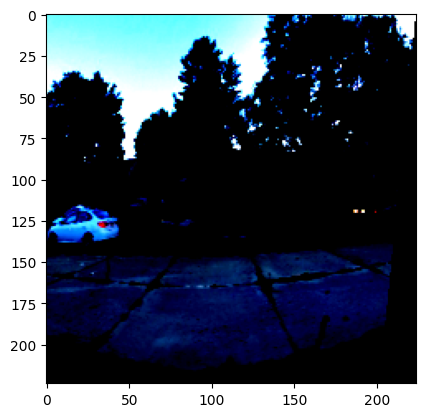

In [9]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

plt.imshow(img_custom[0].permute(1, 2, 0))

# **Model**

In [10]:
# Define Architecture

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class PretrainedResnext32(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = torchvision.models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 4)
        
    def forward(self, xb):
        return self.network(xb)

# **Training**

In [12]:
import numpy as np

def calculate_iou(boxA, boxB):
    """
    Calculates the intersection over union (IoU) between two bounding boxes.

    Args:
        boxA (list): A list of four coordinates representing the first bounding box in the format [x1, y1, x2, y2].
        boxB (list): A list of four coordinates representing the second bounding box in the format [x1, y1, x2, y2].

    Returns:
        float: The IoU between the two bounding boxes.
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def calculate_mAP(y_true, y_pred, iou_threshold=0.5):
    """
    Calculates the mean average precision (mAP) of a model for object detection.

    Args:
        y_true (list): A list of lists representing the ground truth bounding boxes for each image in the dataset.
                        Each inner list contains four coordinates representing a bounding box in the format [x1, y1, x2, y2].
        y_pred (list): A list of lists representing the predicted bounding boxes for each image in the dataset.
                        Each inner list contains four coordinates representing a bounding box in the format [x1, y1, x2, y2].
        iou_threshold (float, optional): The IoU threshold above which a predicted bounding box is considered a true positive.
                                         Defaults to 0.5.

    Returns:
        float: Mean average precision (mAP).
    """
    mAP = 0.0
    n_samples = len(y_true)
    tp = np.zeros(n_samples)
    fp = np.zeros(n_samples)

    for i in range(n_samples):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]

        iou = calculate_iou(y_pred_i, y_true_i)
        if iou >= iou_threshold:
            tp[i] = 1
        else:
            fp[i] = 1

    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    recall = tp / n_samples
    precision = tp / (tp + fp + 1e-10)
    mAP = np.mean(precision)

    return mAP

def calculate_mAP_iou_range(y_true, y_pred, iou_thresholds=[0.5]):
    """
    Calculates the mean average precision (mAP) of a model for object detection over a range of IoU thresholds.

    Args:
        y_true (list): A list of lists representing the ground truth bounding boxes for each image in the dataset.
                        Each inner list contains four coordinates representing a bounding box in the format [x1, y1, x2, y2].
        y_pred (list): A list of lists representing the predicted bounding boxes for each image in the dataset.
                        Each inner list contains four coordinates representing a bounding box in the format [x1, y1, x2, y2].
        iou_thresholds (list, optional): A list of IoU thresholds to evaluate the performance of the model at.
                                         Defaults to [0.5].

    Returns:
        float: Mean average precision (mAP) over a range of IoU thresholds.
    """
    mAP = 0.0
    n_samples = len(y_true)
    tp = np.zeros((n_samples, len(iou_thresholds)))
    fp = np.zeros((n_samples, len(iou_thresholds)))

    for i in range(n_samples):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]

        for j, iou_thresh in enumerate(iou_thresholds):
            iou = calculate_iou(y_pred_i, y_true_i)
            if iou >= iou_thresh:
                tp[i, j] = 1
            else:
                fp[i, j] = 1

    fp = np.cumsum(fp, axis=0)
    tp = np.cumsum(tp, axis=0)
    recall = tp / n_samples
    precision = tp / (tp + fp + 1e-10)
    mAP = np.mean(precision, axis=1)

    return np.mean(mAP)


In [14]:
# Setup loss function and optimizer
model = PretrainedResnext32()
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)
        
to_device(model, device);
lf = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)
map50 = 0.0
map75 = 0.0
map95 = 0.0
map5095 = 0.0
epochs = 40

train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):

        X = X.to(device)
        y = y.to(device)
        model.train()
        
        # Forward
        y_pred = model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss)
    
    test_loss, test_acc= 0, 0
    map50, map75, map95, map5095 = 0.0,0.0,0.0,0.0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            map50 += calculate_mAP(y, test_pred, iou_threshold=0.5)
            map75 += calculate_mAP(y, test_pred, iou_threshold=0.75)
            map95 += calculate_mAP(y, test_pred, iou_threshold=0.95)
            map5095 += calculate_mAP_iou_range(y, test_pred, np.arange(0.5, 1.0, 0.05))
            
        test_loss /= len(test_dataloader_custom)
        map50 /= len(test_dataloader_custom)
        map75 /= len(test_dataloader_custom)
        map95 /= len(test_dataloader_custom)
        map5095 /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss)
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}\n")
    print("Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = "+str(map5095))
    print("Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = "+str(map50))
    print("Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = "+str(map75))
    print("Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets=100 ] = "+str(map95))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 0 | Train loss: 0.12844 | Test loss: 0.09727

Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033750641843819526
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.19288935815333952
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.0
Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets=100 ] = 0.0

Epoch: 1 | Train loss: 0.09183 | Test loss: 0.09258

Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052716105785493184
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.1570836835729114
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.0
Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets=100 ] = 0.0

Epoch: 2 | Train loss: 0.09160 | Test loss: 0.08614

Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.05650344274252636
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets

# **Evaluation**

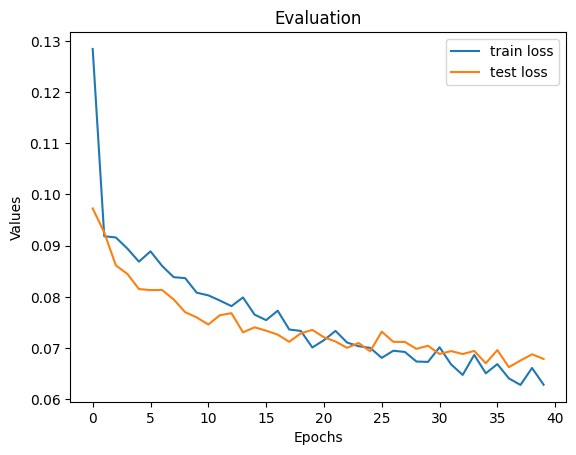

In [15]:
train_loss = []
test_loss = []

for i in train_loss_arr:
    train_loss.append(i.cpu().detach().numpy())
    
for i in test_loss_arr:
    test_loss.append(i.cpu().detach())

plt.plot([i for i in range(epochs)], train_loss, label='train loss')
plt.plot([i for i in range(epochs)], test_loss, label='test loss')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend();

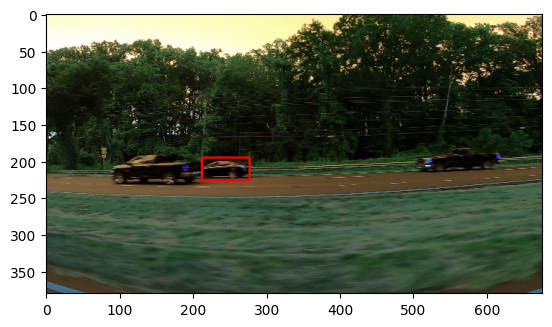

In [16]:
model.eval() 
with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader_custom):
            
        X = X.to(device)
        y = y.to(device)
            
        # Forward
        test_pred = model(X)

idx = 0

test_pred_0 = test_pred[idx]
y_0 = y[idx]
X_0 = X[idx]

actual_corr = scaler.inverse_transform([y_0.cpu().numpy()])
predicted_corr = scaler.inverse_transform([test_pred_0.cpu().numpy()])

image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = actual_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

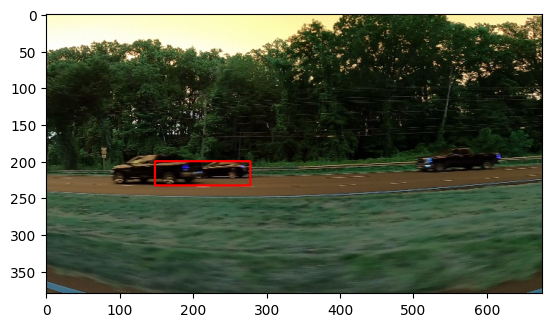

In [17]:
image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = predicted_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

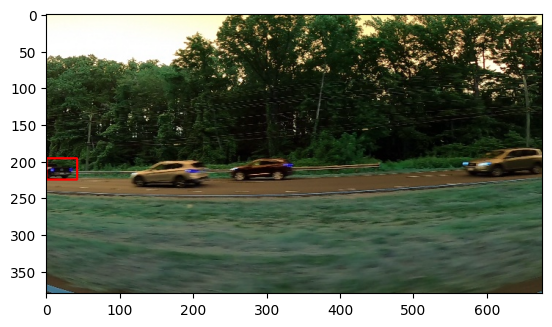

In [18]:
idx = 10

test_pred_0 = test_pred[idx]
y_0 = y[idx]
X_0 = X[idx]

actual_corr = scaler.inverse_transform([y_0.cpu().numpy()])
predicted_corr = scaler.inverse_transform([test_pred_0.cpu().numpy()])

image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = actual_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

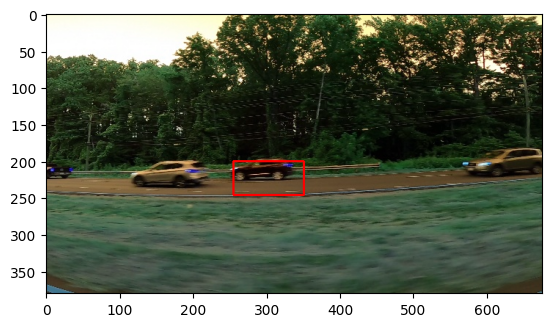

In [19]:
image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = predicted_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)